In [33]:
import warnings
warnings.filterwarnings("ignore")
import wrangle as w
import functions as f

import pandas as pd
import numpy as np

#splits
from sklearn.model_selection import train_test_split

#visualization
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

#scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import precision_score, accuracy_score, recall_score, classification_report

#model
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression


# Project Description
* Using the Austin Animal Center data from 2013 to present, our team will create a model to best predict whether an cat or dog will be adopted. The purpose is to give insight to animal shelters that can use the model as a tool to decide where to focus resources to increase adoption rates. The key is early intervention for cats/dogs to increase adoption resources on those with lower rates of adoption.

# Project Goal
* Discover drivers of outcome
* Use drivers of outcomes to develop machine learning models to predict outcomes
* Identify Animals who are not likely to be adopted
* Provide data based solutions to reduce outcomes of "other"
* Present our options to our stakeholders

# Initial Thoughts

* Our initial hypothesis is that the drivers of outcome will be breed, age, condition, species, and sex.

## Acquire
* The data was aquired on `10 July 2023`
* Two datasets downloaded from data.austintexas.gov: [Intake Dataset](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm) & [Outcome Dataset](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238)
* Intake Dataset: 153,077 rows and 12 columns 
* Outcome Dataset: 153,449 row and 12 columns
* Each row represents an animal's case
* Each column represents features of the animal

## Prepare
- Two dataframes were created, model_df with encoded variables
- Altered column names for readability, and convenience
- Dropped nulls, duplicate ids, species other than cats and dogs
- Converted data types of various columns to appropriate ones such as 'dates' from string to datetime
- Columns were renamed
- Added Features: sex, breed, condition, outcome_age, rel_month, rel_year, primary_color, is_tabby, mix_color 
- Removed Features: id, name_x, monthyear_x, animal type_x, sex upon intake, age upon outcome, breed_x, color_x, monthyear_y, found location, age upon intake, outcome subtype, intake_datetime, outcome_datetime, outcome_date, intake_date
- Split data into train, validate and test (approx. 60/20/20), stratifying on 'outcome'
- Outliers were not adressed as they were part of the target


In [2]:
# acquire and join dfs
df = w.left_join_csv("austin_animal_outcomes.csv","austin_animal_center_intakes.csv", "df")

In [3]:
df.head()

,Animal ID,Name_x,DateTime_x,MonthYear_x,Date of Birth,Outcome Type,Outcome Subtype,Animal Type_x,Sex upon Outcome,Age upon Outcome,...,DateTime_y,MonthYear_y,Found Location,Intake Type,Intake Condition,Animal Type_y,Sex upon Intake,Age upon Intake,Breed_y,Color_y
0,A794011,Chunk,05/08/2019 6:20:00 PM,May 2019,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,...,05/02/2019 04:51:00 PM,May 2019,Austin (TX),Owner Surrender,Normal,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 4:02:00 PM,Jul 2018,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,...,07/12/2018 12:46:00 PM,July 2018,7201 Levander Loop in Austin (TX),Stray,Normal,Dog,Intact Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,08/16/2020 11:38:00 AM,Aug 2020,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,...,08/16/2020 10:10:00 AM,August 2020,Armadillo Rd And Clubway Ln in Austin (TX),Wildlife,Sick,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,02/13/2016 5:59:00 PM,Feb 2016,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,...,02/08/2016 11:05:00 AM,February 2016,Dove Dr And E Stassney in Austin (TX),Stray,Normal,Dog,Intact Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A720371,Moose,02/13/2016 5:59:00 PM,Feb 2016,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,...,02/15/2016 10:37:00 AM,February 2016,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff


In [4]:
#pulling in prepare function from functions.py, creating two dataframes, "df" and "model_df"
df, model_df = w.prep_df(df)

# pre exploration split: train, validate test
train, validate, test = w.split_data(df, 'outcome')

train -> (66040, 14), 60.0%
validate -> (22014, 14),20.0%
test -> (22014, 14), 20.0%


### Sneak Peak at the Data


In [5]:
# overview of data
train.head()

,dob,outcome,sex,name,intake_type,condition,species,breed,outcome_age,rel_month,rel_year,primary_color,is_tabby,mix_color
64069,2019-05-01,adoption,neutered male,1,stray,normal,cat,mix,112,aug,2019,black,0,1
137739,2014-08-30,other,intact male,1,stray,medical attention,cat,mix,19,sep,2014,brown,1,1
17581,2019-04-06,adoption,neutered male,1,owner surrender,normal,dog,mix,1468,apr,2023,tan,0,1
150725,2013-02-11,adoption,neutered male,1,stray,normal,dog,two breeds,1146,apr,2016,brown,0,1
5361,2020-12-15,adoption,spayed female,1,stray,normal,dog,mix,562,jun,2022,black,0,1


# Exploration

* Confidence Interval: 95%

### Exploratory Questions: 
- What is the Percentage of Dogs and Cats?
- Are Months Related to Dogs/Cats Adoptablility?
- Is Breed Related to Outcome?
- Is Sex Related to Outcome?
- Is Species Related to Outcome?
- Is Condition Related to Outcome
- Is Intake Type Related to Outcome?
- Is Multi-Color Coat Related to Outcome?
- Are Tabby Pattern Coats Related to Outcome?
- Is Primary Coat Color Related to Outcome?

### What is the Percentage of Dogs and Cats?
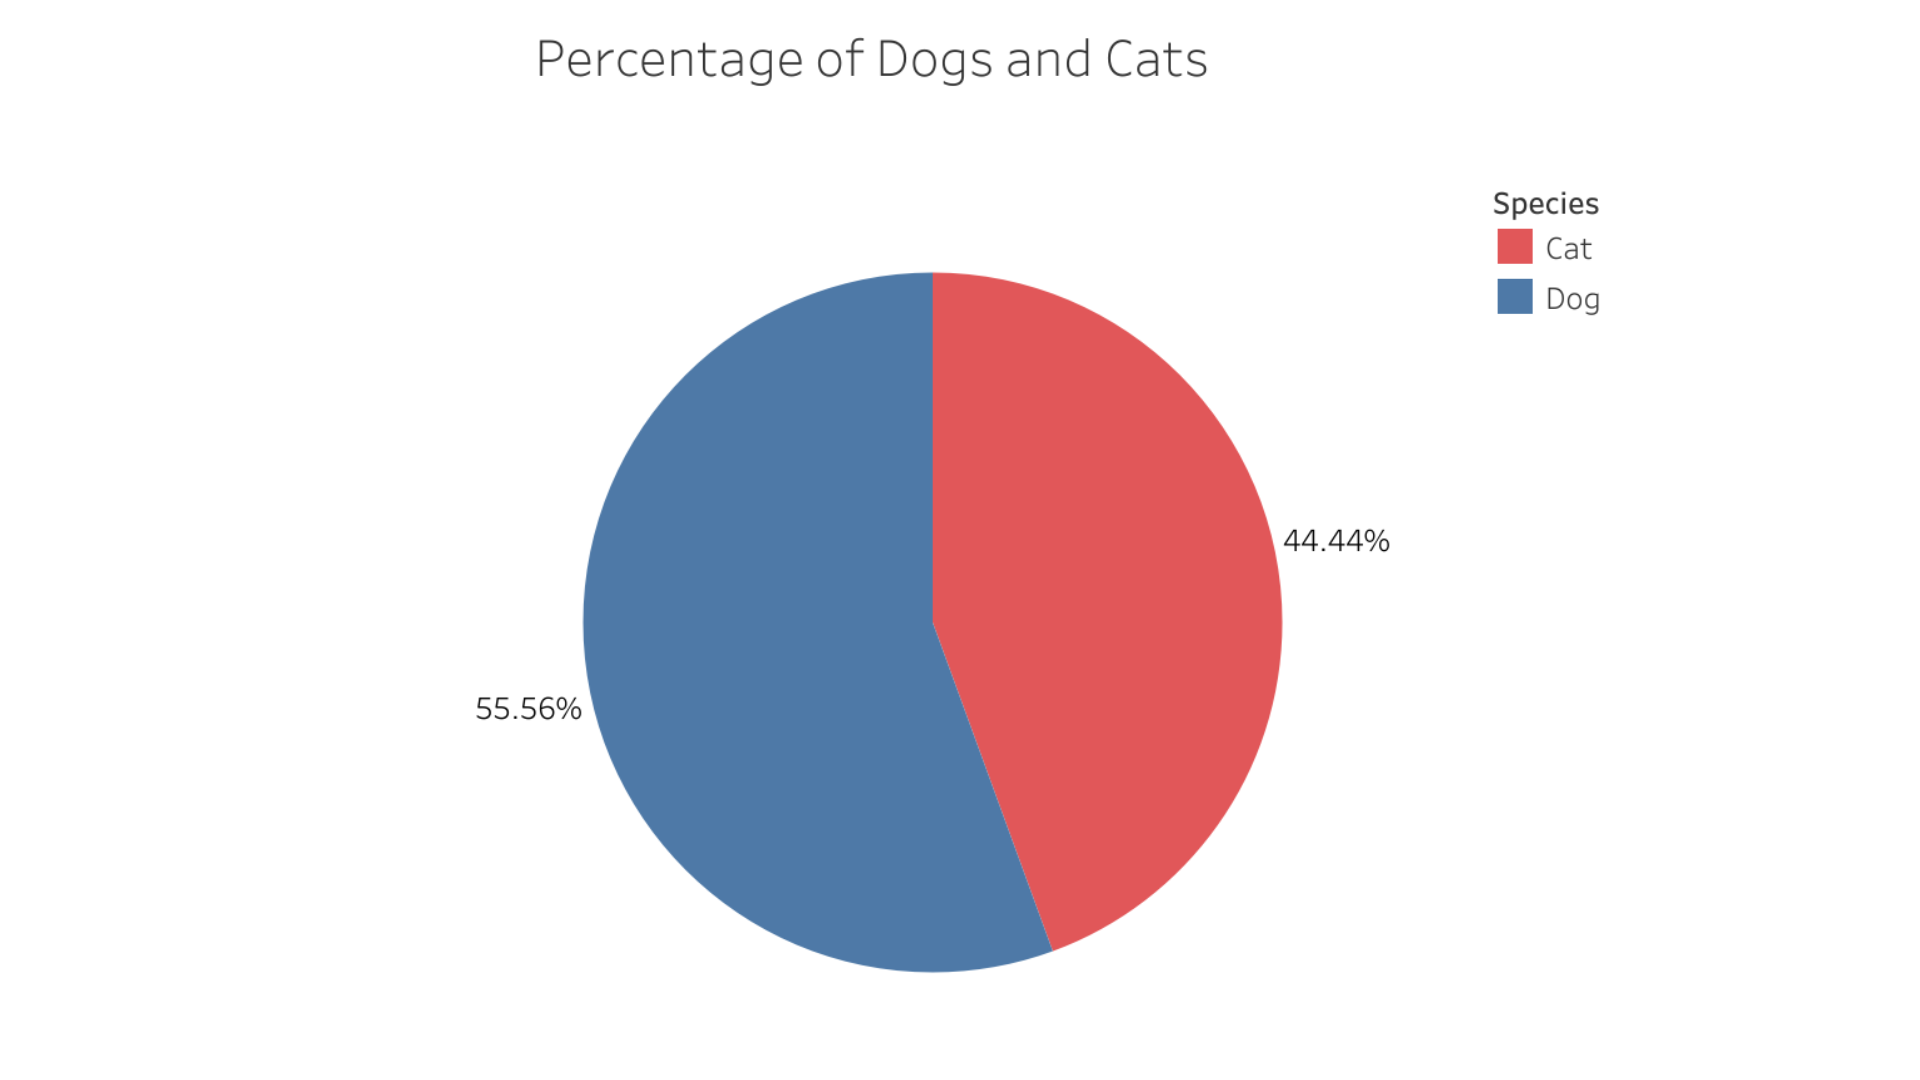

### Percentage of Dogs an Cats that Are Adopted?
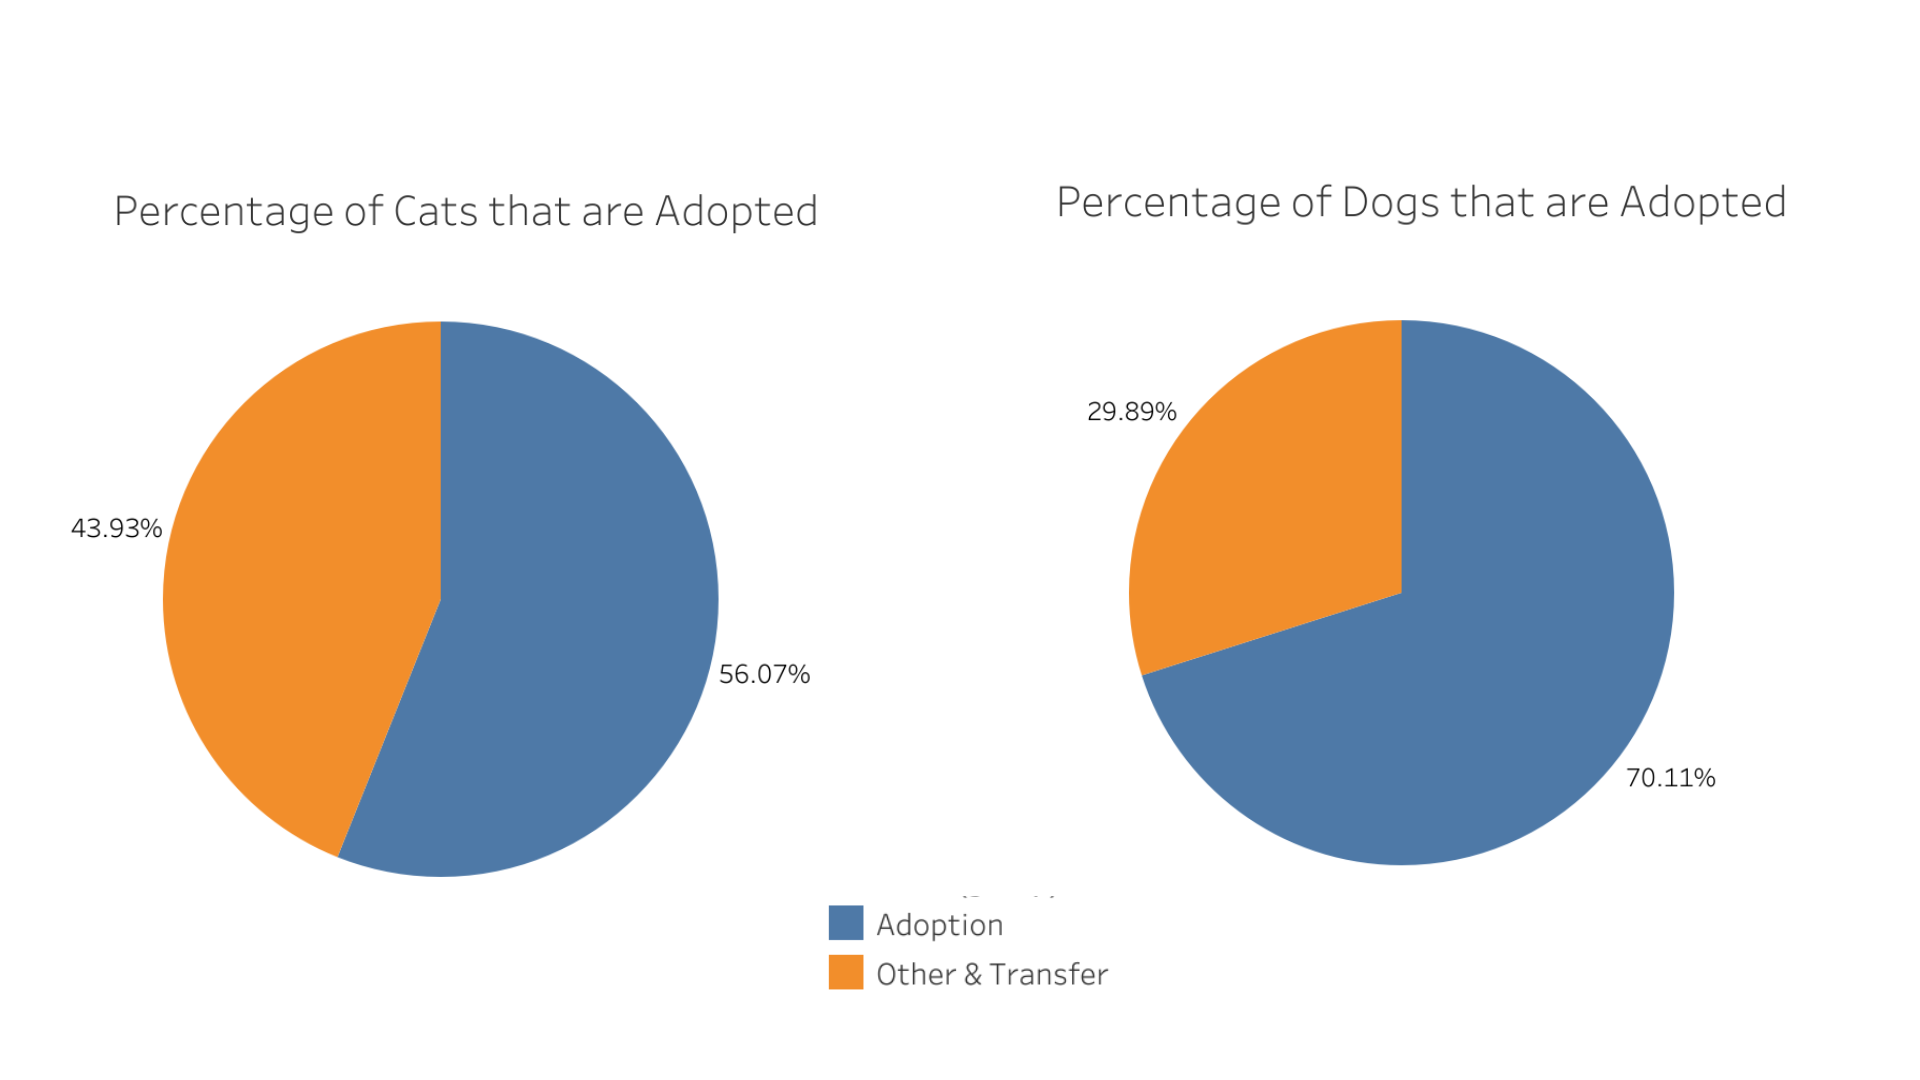

### Q1. Are Months Related to Dogs/Cats Adoptablility?

* $Ho$ = There is no relationship between cats/dogs months and outcome.
* $Ha$ = There is a relationship between cats/dogs months and outcome.

#### Dogs

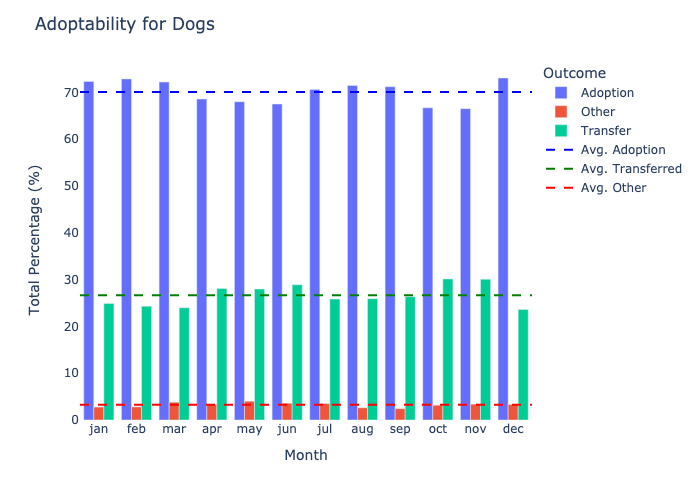

In [6]:
dog_mask = train[train.species == "dog"]
f.month_viz(dog_mask, "outcome", "Adoptability for Dogs")

In [7]:
f.chi_stats(dog_mask, "rel_month", "outcome")

,Chi-square statistic,p-value,Decision
0,122.697973,5.629724e-16,Reject Null Hypothesis


#### Cats

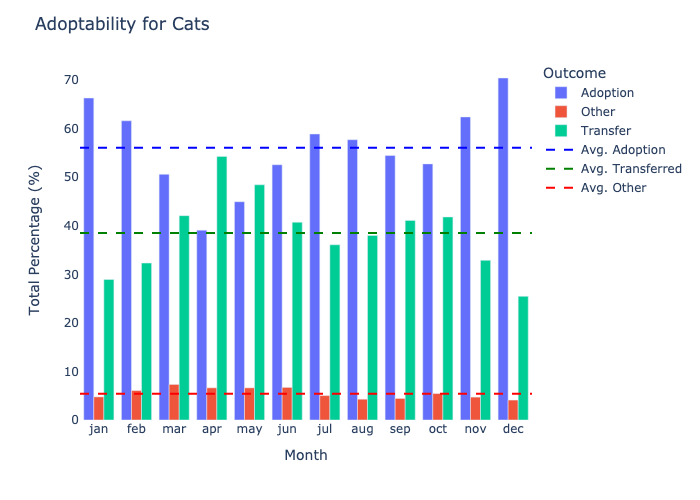

In [8]:
cat_mask = train[train.species == "cat"]
f.month_viz(cat_mask, "outcome", "Adoptability for Cats")

In [9]:
f.chi_stats(cat_mask, "rel_month", "outcome")

,Chi-square statistic,p-value,Decision
0,756.539653,8.899374e-146,Reject Null Hypothesis


The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small

####  Observations: 
* Dogs: 
    * There is a higher volumes of adoption occur in December, January, February, and March for dogs.
    * There is a lower volumes of adoption occur in April, May, June, September, October, and November for dogs.
* Cats:
    * There is a higher volumes of adoption occur in December, January, February, July, and August for cats.
    * There is a lower volumes of adoption occur in March, April, May, June, September, and October for cats.

*Based on the result of our test and the observations in the chart, we can infer that month has some correlation to their final outcome. Therefore, we will use this feature in our model.

### Q2. Is Breed Related to Outcome?

* $Ho$ = There is no relationship between breed and outcome.
* $Ha$ = There is a relationship between breed and outcome.

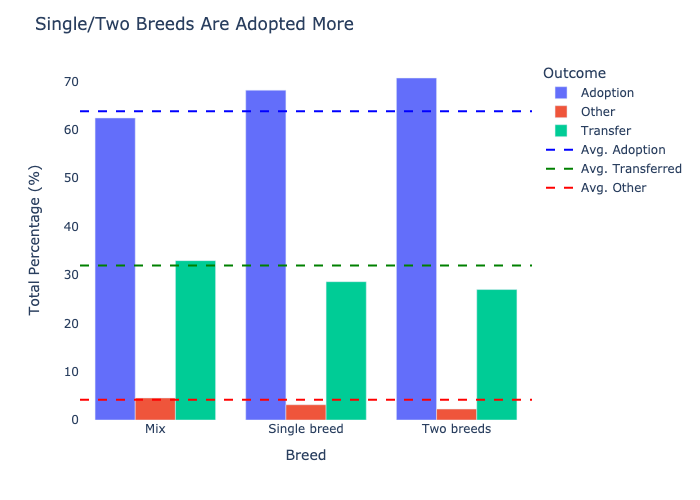

In [10]:
f.px_viz(train, "breed", "outcome", "Breed", 'Single/Two Breeds Are Adopted More')

In [11]:
f.chi_stats(train, "breed", "outcome")

,Chi-square statistic,p-value,Decision
0,258.839347,8.111347e-55,Reject Null Hypothesis


The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small

####  Observations: 
* There is a higher volume of mixed breeds that are not adopted or transfered
* Mixed breeds are more likely to be transfered or adopted

*Based on the result of our test and the observations in the chart, we can infer that animal breed  has some correlation to their final outcome. Therefore, we will use this feature in our model.

### Q3  Is Sex Related to Outcome?

* $Ho$ = There is no relationship between sex and outcome.
* $Ha$ = There is a relationship between sex and outcome.

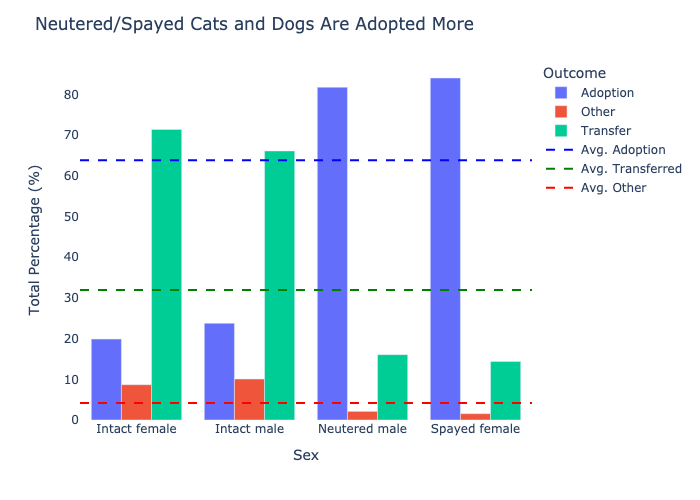

In [12]:
f.px_viz(train, "sex", "outcome", 'Sex', 'Neutered/Spayed Cats and Dogs Are Adopted More')

In [13]:
f.chi_stats(train, "sex", "outcome")

,Chi-square statistic,p-value,Decision
0,23023.75966,0.0,Reject Null Hypothesis


The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small.

####  Observations: 
* We can clealy observe a difference in outcomes between intact and fixed animals
    * Fixed animals are far more likely to be adopted
    * This is likly due to the common policy of animal rescues fixing animals before adoption
* Intact males are slightly more likely to have an ‘other’ outcome than intact females
* Intact females are slightly more likely to be transfered than intact males

*Based on the result of our test and the observations in the chart, we can infer that animal sex  has some correlation to their final outcome. Therefore, we will use this feature in our model.

### Q4.  Is Species Related to Outcome?

* $Ho$ = There is no relationship between species and outcome.
* $Ha$ = There is a relationship between species and outcome.

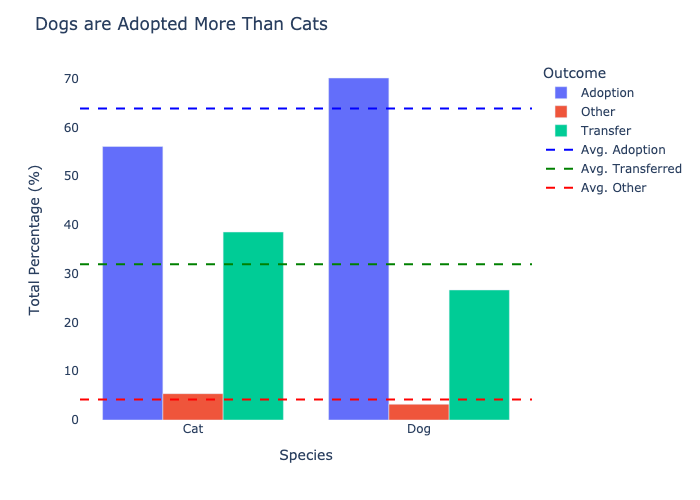

In [14]:
f.px_viz(train, "species", "outcome", 'Species', 'Dogs are Adopted More Than Cats')

In [15]:
f.chi_stats(train, "species", "outcome")

,Chi-square statistic,p-value,Decision
0,1405.711162,5.671523e-306,Reject Null Hypothesis


The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small

####  Observations: 
* Among dogs a higher percentage were adopted compared to cats
29289 cats, 36758 dogs
    * ~55% of cats were adopted vs ~70% of dogs, while cats more likely to be transfered ~39% for cats, ~27% for dogs
* Cats are slightly more likely to have an ‘other’ or transfer outcome than dogs

*Based on the result of our test and the observations in the chart, we can infer that species type has some correlation to their final outcome. Therefore, we will use this feature in our model.

### Q5. Is Condition Related to Outcome?
* $Ho$ = There is no relationship between condition and outcome.
* $Ha$ = There is a relationship between condition and outcome.

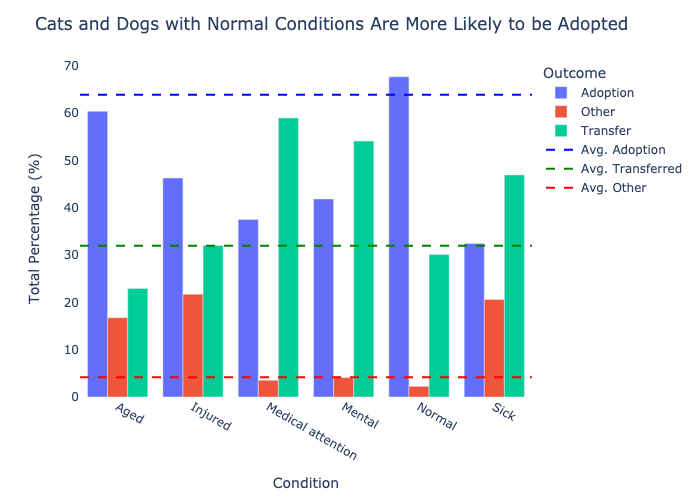

In [16]:
f.px_viz(train, "condition",
         "outcome", 'Condition',
         'Cats and Dogs with Normal Conditions Are More Likely to be Adopted')

In [17]:
f.chi_stats(train, "condition", "outcome")

,Chi-square statistic,p-value,Decision
0,6845.51901,0.0,Reject Null Hypothesis


The Chi-squared statistic indicates substantial difference between the observed and expected frequencies

####  Observations: 
* Cats and dogs with normal conditions are more likely to be adopted.
    * Aminals with conditions such as sick, medical attention, or mental were more likely to be transferred
    `possibly due to outsourcing for medical needs`
    * Injured Cats and dogs are more likely to be adopted.

*Based on the result of our test and the observations in the chart, we can infer that condition has some correlation to their final outcome. Therefore, we will use this feature in our model.

### Q6. Is Intake Type Related to Outcome?
* $Ho$ = There is no relationship between intake_type and outcome.
* $Ha$ = There is a relationship between intake_type and outcome.

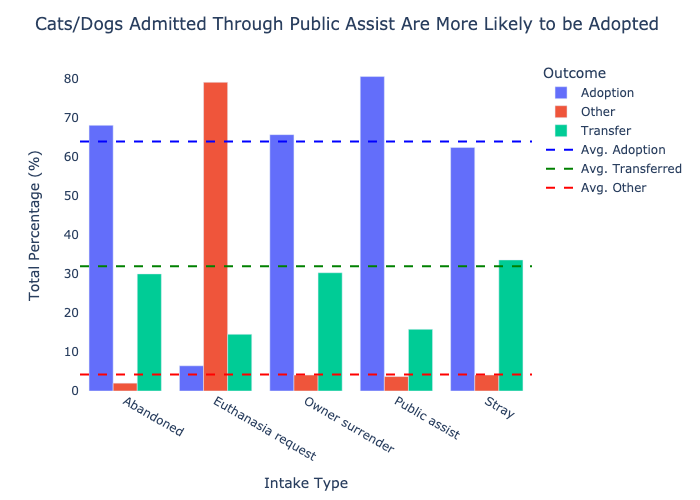

In [18]:
f.px_viz(train, "intake_type",
         "outcome", 'Intake Type',
         "Cats/Dogs Admitted Through Public Assist Are More Likely to be Adopted")

The Chi-squared statistic indicates substantial difference between the observed and expected frequencies

####  Observations: 
* Cats and dogs that came in as abandoned, owner surrender, or public assist are more likely to be adopted.
* Cats and dogs that came in as stray are less likely to be adopted 

**Based on the result of our test and the observations in the chart, we can infer that intake type has some correlation to their final outcome. Therefore, we will use this feature in our model.**

### Q7.  Are Multi-Color Coats Related to Outcome?

* $Ho$ = There is no relationship between mix_color and outcome.
* $Ha$ = There is a relationship between mix_color and outcome.

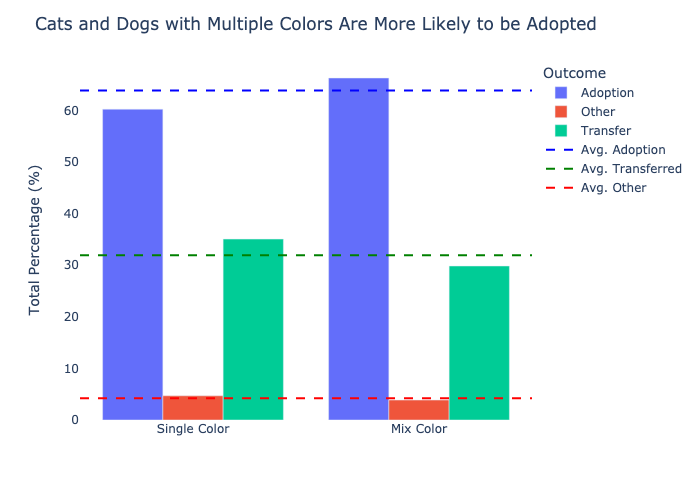

In [20]:
f.px_num_viz(train, 
           "mix_color",
           "outcome", 
           'Cats and Dogs with Multiple Colors Are More Likely to be Adopted', 
           tick_labels=["Single Color", "Mix Color"])

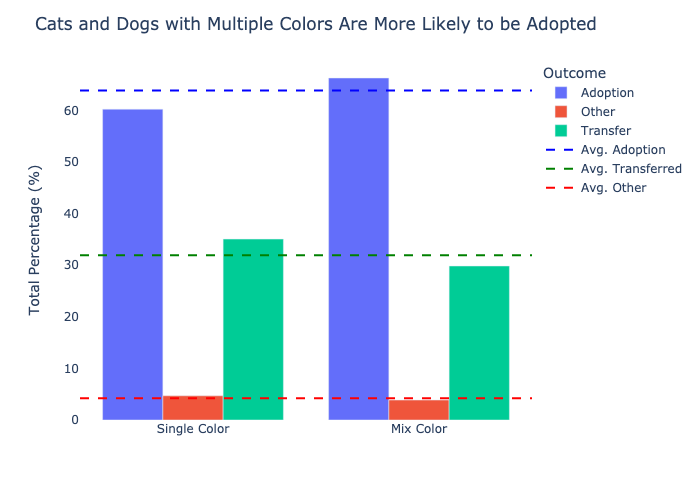

In [21]:
f.px_num_viz(train, 
           "mix_color",
           "outcome", 
           'Cats and Dogs with Multiple Colors Are More Likely to be Adopted', 
           tick_labels=["Single Color", "Mix Color"])

In [22]:
f.chi_stats(train, "mix_color", "outcome")

,Chi-square statistic,p-value,Decision
0,251.848185,2.050508e-55,Reject Null Hypothesis


The Chi-squared statistic indicates substantial difference between the observed and expected frequencies

####  Observations: 
* Cats and dogs with multi-colored coats are more likely to be adopted.
* Cats and dogs with single-colored coats are more likely to be transferred.

**Based on the result of our test and the observations in the chart, we can infer that multi-colored has some correlation to their final outcome. Therefore, we will use this feature in our model.**

### Q8. Are Tabby Cat Patterns Related to Outcome?

* $Ho$ = There is no relationship between is_tabby and outcome.
* $Ha$ = There is a relationship between is_tabby and outcome.

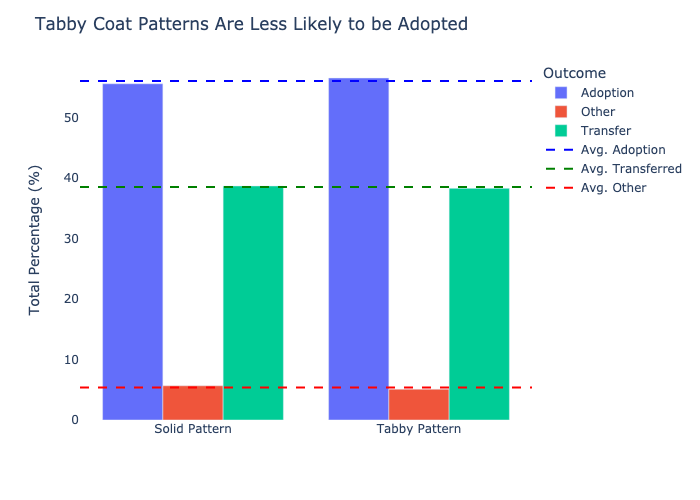

In [23]:
f.px_num_viz(cat_mask, 
           "is_tabby",
           "outcome", 
           'Tabby Coat Patterns Are Less Likely to be Adopted',
           tick_labels=["Solid Pattern", "Tabby Pattern"])

In [24]:
f.chi_stats(cat_mask, "is_tabby", "outcome")

,Chi-square statistic,p-value,Decision
0,5.681031,0.058396,Reject Null Hypothesis


The Chi-squared statistic that there is no substantial difference between the observed and expected frequencies

####  Observations: 
* Tabby Cat patterns are not significant to their outcome. This test was only ran on cats because they were the only species that have a tabby pattern in this data. 

**Based on the result of our test and the observations in the chart, we can infer that a cat's tabby pattern has no correlation to their final outcome. Therefore, this feature will not continue to modeling.**

### Q9.  Are Primary Coat Color For Species Related to Outcome?

* $Ho$ = There is no relationship between primary_color for species and outcome.
* $Ha$ = There is a relationship between primary_color for species and outcome.

#### Dogs

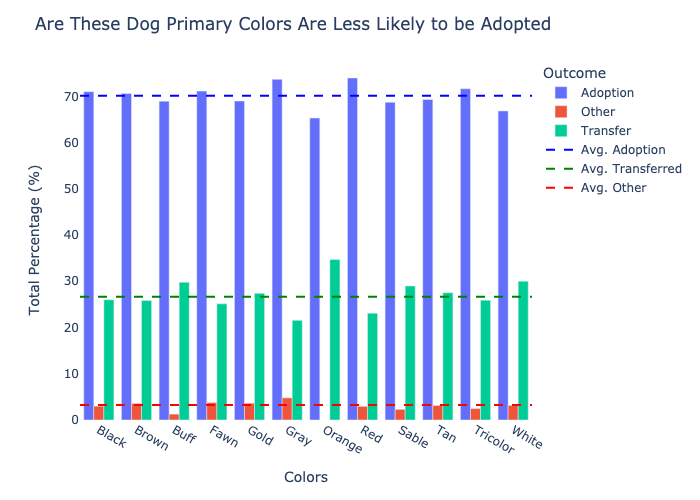

In [25]:
dog_mask = train[train.species == "dog"]
f.px_viz(dog_mask, "primary_color", "outcome", "Colors", 'Are These Dog Primary Colors Are Less Likely to be Adopted')

In [26]:
f.chi_stats(dog_mask, "primary_color", "outcome")

,Chi-square statistic,p-value,Decision
0,124.044501,3.196067e-16,Reject Null Hypothesis


#### Cats

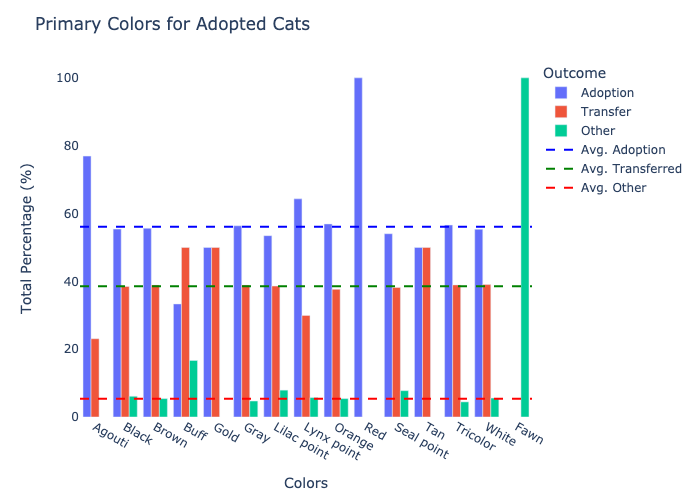

In [27]:
f.px_viz(cat_mask, "primary_color", "outcome", "Colors", "Primary Colors for Adopted Cats")

In [28]:
f.chi_stats(cat_mask, "primary_color", "outcome")

,Chi-square statistic,p-value,Decision
0,65.599437,0.000075,Reject Null Hypothesis


The Chi-squared statistic indicates substantial difference between the observed and expected frequencies

####  Observations: 
* Dog's with the primary color gray and red are more likely to be adopted and will continue to modeling. The remaining colors will also not move to modeling. 
* Cat's with the primary color agouti, lynx point, and red are more likely to be adopted and will continue to modeling. Fawn is a single occurence and and will not be considered for modeling. The remaining colors will also not move to modeling. 
 
**Based on the result of our test and the observations in the chart, we can infer that condition has some correlation to their final outcome. Therefore, we will use this feature in our model.**

## Exploration Summary
- Identifed features that have a significant relationship with outcome:
    * rel_month: 
        * Dogs are adopted more in December, January, February, and March and less in April, May, June, September, October, and November.
        * Cats are adopted more in December, January, February, July, and August and less in March, April, May, June, September, and October.
    * breeds: Mixed breeds are more likely to be transfered or adopted
    * sex: Fixed animals are far more likely to be adopted
    * species: Among dogs a higher percentage were adopted compared to cats
    * intake_type: 
        * Cats and dogs that came in as abandoned, owner surrender, or public assist are more likely to be adopted.
        * Cats and dogs that came in as stray are less likely to be adopted 
    * condition: Cats and dogs with normal conditions are more likely to be adopted.
    * mix_color: Cats and dogs with single-colored coats are more likely to be transferred
    * primary_color:
        * Dog's with the primary color gray and red are more likely to be adopted
        * Cat's with the primary color agouti, lynx point, and red are more likely to be adopted
    
- Features that will not be continuing to modeling:
    * Year_rel: Showed overall trend and would not be a accurate prediction
    * Dob: Data integrity issued was raised when we found negative ages
    * Outcome_age: Data integrity issued was raised when we found negative ages
    * Is_tabby: No statisical significance     


## Modeling

**We will alter our outcome column by combining `transfer` and `other`, our model will only classify adoption or other**
- Evaluation Meteric: Accuracy
- Target is outcome
- Baseline: 63.3% (adopted)
- Models will be developed using a few different types, various features, and various hyperparameter configurations
    - KNN
    - Logistic Regression
    - Decision Tree Classifier
    - Random Forest Classifier
    - Support Vector Machine
- Models will be evaluated on Train and Validate
- Best performing model will only be evaluated on Test

In [29]:
# get x and y variables
x_train,y_train,x_validate,y_validate,x_test,y_test = f.get_xy(model_df, "outcome")

train -> (66040, 22), 60.0%
validate -> (22014, 22),20.0%
test -> (22014, 22), 20.0%


In [30]:
# get models - train and validate scores
model_scores = f.get_models(x_train,y_train,x_validate,y_validate)

In [31]:
model_scores

,model,set,accuracy
0,k_nearest_neighbors,train,0.822865
1,k_nearest_neighbors,validate,0.821159
2,logistic_regression,train,0.822305
3,logistic_regression,validate,0.819978
4,DecisionTreeClassifier,train,0.815127
5,DecisionTreeClassifier,validate,0.812574
6,random_forest,train,0.746684
7,random_forest,validate,0.745980
8,support_vector_machine,train,0.824833
9,support_vector_machine,validate,0.822204


# Comparing Models
Baseline: 63.87
* The KNN Model yielded a train accuracy of 82.28 and a validate accuracy of 82.11
* The Logistics Regression Model yielded a train accuracy of 82.23 and a validate accuracy of 81.99
* The Decision Tree Model yielded a train accuracy of 81.51 and a validate accuracy of 81.25
* The Random Forest Model yielded a train accuracy of 74.66 and a validate accuracy of 74.59
* The Support Vector Machine Model yielded a train accuracy of 82.48 and a validate accuracy of 82.22
* The Naive Bayes Model yielded a train accuracy of 71.98 and a validate accuracy of 72.13
* The Gradient Boosting Model yielded a train accuracy of 82.39 and a validate accuracy of 82.23

# Model Selection
* The Support Vector Model maintained a 82.35 % average accuracy with only a 0.026 differential in both train and validate. While most of the models did well with the exception of the Naive Bayes model, there were slight variances between the train and validate sets. We beat the baseline accuracy score of 63.87% by 18.48% when using the average of the Support Vector Model. We will move forward with the Support Vector Model using the final test data set.

In [32]:
f.run_support_vector(x_train, y_train, x_test, y_test)

,model,set,accuracy
0,support_vector,test,0.827837


# Model Summary
* The Gradient Boost model had a test accuracy score of 79.8%, which is approximately 16% greater than the baseline. 

## Report - Takeaways & Conclusions

### Exploration 
`Features in Model:`
   * rel_month, breeds, sex, species, intake_type, condition, mix_color, and primary_color

`Features not in Model:`
   * Year_rel, dob, and outcome_age did not move to modeling because data integrity was an issue or would not be a accurate prediction.
    * Is_tabby: No statisical significance     

 
### Recommendations
* Data governance recommendations:
    - We found tens of thousands of rows with data that was missing and/or had nonsensical information
        * Collect more information such as:
            - Incidents (e.g. biting, abuse hx)
            - Stated reason for return
            - Reasons for turn in by owners
            - Vaccination status
            - Who turned the animal in (e.g. citizen, law enforcement, organization)
            - Microchipped
     - Create a database for all animals that are owned
         * Allow for anyone in the city to register their animals with us whether they are being dropped off or not
         * Collect data on those animals
             * Demographic information
             * Microchip
             * Health conditions
 * Business recommendations:
     - Organize special adoption events and campaigns during the months when dogs and cats are adopted less frequently.
         * Focus on promoting the benefits of adopting during these months, highlighting the joy of having a new furry friend for the upcoming year.
         * Put special emphasis on cats and dogs with single color coats
    - Promotional/Marketing Materials:
        * Highlight the unique qualities and/or advantages of owning:
            - Mixed-breed animals
             - Cats
         * Educating the public about:
             - Responsible pet ownership
                 * The importance of spaying and neutering their pets
                 * Leashes
                 * Microchips
                 * Collaring
                 * Properly securing the animal on their property
             - General benefits of owning a pet
             - The adoption pipeline,
                 * Positive stories
                 * The potential for negative outcomes and stories
                 * Emphasis on stray animals, cause and outcomes
    - Identify any points of friction for the adoption process and smoothen the process, provide support and education along the lifecycle of the animal
    - Partner with local business that would be willing to:
        * Host social events for people who adopted animals from our shelter
        * Allow us to use their store fronts
        * Provide discounts for our customers for a certain period of time if they registered their animal
        * provide discounts for collars, vaccines, microchips, and neutering/spaying for animals purchased, and registered with our shelter
        
### Next Steps
* If provided more time we would use NLP to review the polarity of the names.
* Review other shelters with different features
* Research the cause of stray animals